#Section 1 Data Scraping

In [33]:
import requests
import re
import traceback
from bs4 import BeautifulSoup
import csv

def GetHtml(url):
    r = requests.get(url)
    r.raise_for_status()
    r.encoding = 'GB2312'   
    # r.encoding = r.apparent_encoding  # 要解析，速度慢，且容易出错
    return r.text
# 解析html各个产品的url
def GetHtmlforProUrl(url, bn):
    try:
        html = GetHtml(url)
        if len(re.findall('对不起，暂时没有', html)) != 0:
            print(f'{url}没有数据')
            return False
        soup = BeautifulSoup(html, 'html.parser')
        divlis = soup.find_all('div', 'pro-intro')
        for div in divlis:
            a = div.find('a', 'more')
            if a is None:
                continue
            prodetailurl = a.attrs['href']
            GetHtmlAndParserPro(prodetailurl, bn)
    except Exception as e:
        print(e)
        traceback.print_exc(limit=2, file=open('tt.log', 'a+'))
        print(f'GetHtmlforProUrl：{url}发生错误')
    return True

# 辅助函数
def GetSpanString(detaildiv, sname):
    getstr = ''
    try:
        getstr = detaildiv.find('span', string=sname).find_parent('tr').find('td').find('span').string
        # print(getstr)
    except Exception as e:
        # print('没有', sname)
        it = ''
    return getstr


In [ ]:
# 解析获取产品的详细
def GetHtmlAndParserPro(prodetailurl, bn):
    try:
        baseurl = 'https://detail.zol.com.cn'
        html = GetHtml(baseurl + prodetailurl)
        soup = BeautifulSoup(html, 'html.parser')
        # 品牌公司名称
        bname = bn
        sidediv = soup.find('div', 'goods-card')# 侧边栏
        # 名称
        bpname = sidediv.find('h3', 'goods-card__title').a.string
        # 价格
        price = sidediv.find('div', 'goods-card__price').span.string
        price = float(re.findall(r'[\d]{1,}', price)[0])
        # 评分会空
        try:
            score = sidediv.find('div', 'goods-card__score').find('span', 'score').string
            score = score[0:-1]
            # 点评人数
            comentct = sidediv.find('div', 'goods-card__score').find('a', 'j_praise').string
            comentct = comentct[0:comentct.find('条')]
        except Exception as e:
            score = 0
            comentct = 0
            print(e)
        # 详细div
        detaildiv = soup.find_all('div','wrapper')[1].find_all('div', 'section')[1]
        sssj = GetSpanString(detaildiv, '上市时间')
        sssjn = sssj[0:sssj.find('年')] #年份
        sssjy = sssj[sssj.find('年') + 1:sssj.find('月')] #月份
        yxncs = GetSpanString(detaildiv, '系统内存')
        yxnc = yxncs[0:yxncs.find('G')]
        if yxncs != '' and yxncs.find('M') != -1:
            yxnc = float(re.findall(r'[\d]{1,}', yxncs)[0]) / 1024
        ccrls = GetSpanString(detaildiv, '存储容量')
        ccrl = ccrls[0:ccrls.find('G')]
        if ccrls != '' and ccrls.find('T') != -1:
            ccrl = float(re.findall(r'[\d]{1,}', ccrls)[0]) * 1024
        czxt = GetSpanString(detaildiv, '操作系统')
        clxxh = GetSpanString(detaildiv, '处理器型号')
        pmcc = GetSpanString(detaildiv, '屏幕尺寸')
        pmcc = pmcc[0:pmcc.find('英')]
        pmfbl = GetSpanString(detaildiv, '屏幕分辨率')
        cpzl = GetSpanString(detaildiv, '产品重量')
        cpzl = cpzl[0:cpzl.find('g')]
        dclx = GetSpanString(detaildiv, '电池类型')
        dcrl = ''
        # 电池类型是否包含了电池容量
        if dclx != '' and dclx.find('，') != -1:
            dcrl = dclx[dclx.find('，')+1:]
            # 电池类型不要包含容量
            dclx = dclx[0:dclx.find('，')]
        else:
            dcrl = GetSpanString(detaildiv, '电池容量')
        dxrls = re.findall(r'[\d.\d]{1,}', dcrl)
        if len(dxrls) == 1:
            dcrls = dcrl
            dcrl = float(dxrls[0])
            if dcrl != '' and dcrls.find('瓦') != -1:
                dcrl = int(dcrl * 1000 / 3.7)
        # xhsj = GetSpanString(detaildiv, '续航时间')
        print(f'{bpname}, {price}, {score}, {comentct},{sssjn},{sssjy}, {yxnc}, {ccrl}, {czxt}, {clxxh}, {pmcc}, {pmfbl}, {cpzl}, {dclx}, {dcrl}')
        SaveContentToCsv([bname,bpname,sssjn,sssjy,price,yxnc,ccrl,czxt, clxxh,pmcc,pmfbl,cpzl,comentct,score,dclx,dcrl])
    except Exception as e:
        print(e)
        print(f'GetHtmlAndParserPro：{prodetailurl}发生错误')
        traceback.print_exc()
        traceback.print_exc(limit=2, file=open('tt.log', 'a+'))

In [ ]:
# 1. 创建文件对象（指定文件名，模式，编码方式）
f = open("pad_info.csv", "w", encoding="gbk", newline="")
# 2. 基于文件对象构建 csv写入对象
csv_writer = csv.writer(f)
# 3. 构建列表头
csv_writer.writerow(['公司名称','产品名称','上市年份','上市月份','价格(元)','运行内存(GB)','存储容量(GB)','操作系统','处理器型号','屏幕尺寸(英寸)','屏幕分辨率','重量(g)','评论人数','评分','电池类型','电池容量', ])
def SaveContentToCsv(infolist):
    global csv_writer
    csv_writer.writerow(infolist)# 4. 写入csv文件内容

def Main():
    baseUrl = 'https://detail.zol.com.cn/tablepc/'
    brandname = ['苹果', '华为', '小米', '三星', '荣耀', '中柏', '酷比魔方', '台电', '微软', '联想', 'E人E本', '诺基亚',
                 '海信', '索立信', 'vivo', 'OPPO', '松下', 'realme', '谷歌', '海尔', '神基', 'VOYO', '纽麦', '清华同方',
                 'a豆', 'ROG', '睿刚', '集思宝']
    brannamelist = ['apple', 'huawei', 'xiaomi', 'samsung','honor','jumper','kubi','teclast','microsoft','lenovo','eben',
                    'nokia','hisense','soulixin','vivo','oppo','panasonic','realme','google','haier','getac','voyo',
                    'nerlmiay','tongfang','adol','rog','ruggon','jisibao']
    for i in range(0, len(brannamelist)):
        for j in range(1, 25):
            url = baseUrl + brannamelist[i] +'/'+ str(j) +'.html'
            isco = GetHtmlforProUrl(url, brandname[i])
            if not isco:
                break
    # 5. 关闭文件
    f.close()
Main()


苹果iPad 2021（64GB/WiFi版）, 2398.0, 9.4, 6566,2021,08, , 64, iPadOS 15, 苹果 A13, 10.2, 2160x1620, 487, 锂电池, 8756
苹果iPad mini 6（64GB/WiFi版）, 3799.0, 9.4, 2931,2021,09, , 64, iPadOS 15, 苹果 A15, 8.3, 2266x1488, 293, 聚合物锂电池, 5216
苹果iPad Air 5（64GB/WiFi版）, 4399.0, 9.6, 1321,2022,03, 8, 64, iPadOS 15, Apple M1, 10.9, 2360x1640, 461, 聚合物锂电池, 7730.0


KeyboardInterrupt: ignored

#Section 2 Data cleaning

In [9]:
import pandas as pd

##1. Inputting Data

In [10]:
url = "https://raw.githubusercontent.com/Leizisayhelloworld/Jour7280-Final-project/main/pad_Info.csv"
pad_info = pd.read_csv(url)
pad_info

,公司名称,产品名称,上市年份,上市月份,价格(元),运行内存(GB),存储容量(GB),操作系统,处理器型号,屏幕尺寸(英寸),屏幕分辨率,重量(g),评论人数,评分,电池类型,电池容量
0,苹果,苹果iPad 2021（64GB/WiFi版）,2021.0,8.0,2398,NaN,64.0,iPadOS 15,苹果 A13,10.2,2160x1620,487.0,6566,9.4,锂电池,8756
1,苹果,苹果iPad 2022(64GB/WLAN版),2022.0,10.0,3246,NaN,64.0,iPadOS 16,Apple A14,10.9,2360x1640,477.0,479,9.8,聚合物锂电池,7729
2,苹果,苹果iPad mini 6（64GB/WiFi版）,2021.0,9.0,3799,NaN,64.0,iPadOS 15,苹果 A15,8.3,2266x1488,293.0,2931,9.4,聚合物锂电池,5216
3,苹果,苹果iPad Air 5（64GB/WiFi版）,2022.0,3.0,4399,8.0,64.0,iPadOS 15,Apple M1,10.9,2360x1640,461.0,1321,9.6,聚合物锂电池,7730
4,苹果,苹果iPad Pro 11英寸 2022(8GB/128GB/WLAN版),2022.0,10.0,6399,8.0,128.0,iPadOS 16,Apple M2,11.0,2388x1668,466.0,1017,9.8,聚合物锂电池,7743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,联想,联想乐Pad Y1011 WLAN（32GB/3G版）玛奇朵棕,2011.0,1.0,2850,1.0,32.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN
449,联想,联想IdeaPad Yoga11-TTH（日光橙）,2012.0,11.0,2300,2.0,32.0,Windows RT,Nvidia Tegra T30,11.6,1366x768,1240.0,21,6.8,锂电池,NaN
450,联想,联想乐Pad Y1011 WLAN（32GB）百加地白,2011.0,3.0,2300,1.0,32.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN
451,联想,联想乐Pad Y1011 WLAN（16GB/3G版）曼特宁黑,2011.0,1.0,2200,1.0,16.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN


### Comment on 1.
The dataframe have 453 rows and 16 columns

##2. Checking the information about this dataframe

In [11]:
pad_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   公司名称      453 non-null    object 
 1   产品名称      453 non-null    object 
 2   上市年份      411 non-null    float64
 3   上市月份      350 non-null    float64
 4   价格(元)     453 non-null    int64  
 5   运行内存(GB)  354 non-null    float64
 6   存储容量(GB)  421 non-null    float64
 7   操作系统      433 non-null    object 
 8   处理器型号     413 non-null    object 
 9   屏幕尺寸(英寸)  453 non-null    float64
 10  屏幕分辨率     453 non-null    object 
 11  重量(g)     395 non-null    float64
 12  评论人数      453 non-null    int64  
 13  评分        453 non-null    float64
 14  电池类型      396 non-null    object 
 15  电池容量      215 non-null    object 
dtypes: float64(7), int64(2), object(7)
memory usage: 56.8+ KB


###comment on 2.
Apart from columns"上市月份","运行内存(GB)" and "电池容量", the pad information  is partially missing. And the missing value is dencentralized, and the volume is less, so we can not delet them directly. What we want to do is dealing with the missing value in the specific situation. 


##3. Dealing with duplication

In [12]:
duplicate_df = pad_info[pad_info.duplicated()]
print('# of duplicated rows:', duplicate_df.shape[0])

# of duplicated rows: 0


##4. Deleting the useless column ---- Month 

In [13]:
Useful_pad_info = pad_info.drop(['上市月份'], axis = 1)
Useful_pad_info

,公司名称,产品名称,上市年份,价格(元),运行内存(GB),存储容量(GB),操作系统,处理器型号,屏幕尺寸(英寸),屏幕分辨率,重量(g),评论人数,评分,电池类型,电池容量
0,苹果,苹果iPad 2021（64GB/WiFi版）,2021.0,2398,NaN,64.0,iPadOS 15,苹果 A13,10.2,2160x1620,487.0,6566,9.4,锂电池,8756
1,苹果,苹果iPad 2022(64GB/WLAN版),2022.0,3246,NaN,64.0,iPadOS 16,Apple A14,10.9,2360x1640,477.0,479,9.8,聚合物锂电池,7729
2,苹果,苹果iPad mini 6（64GB/WiFi版）,2021.0,3799,NaN,64.0,iPadOS 15,苹果 A15,8.3,2266x1488,293.0,2931,9.4,聚合物锂电池,5216
3,苹果,苹果iPad Air 5（64GB/WiFi版）,2022.0,4399,8.0,64.0,iPadOS 15,Apple M1,10.9,2360x1640,461.0,1321,9.6,聚合物锂电池,7730
4,苹果,苹果iPad Pro 11英寸 2022(8GB/128GB/WLAN版),2022.0,6399,8.0,128.0,iPadOS 16,Apple M2,11.0,2388x1668,466.0,1017,9.8,聚合物锂电池,7743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,联想,联想乐Pad Y1011 WLAN（32GB/3G版）玛奇朵棕,2011.0,2850,1.0,32.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN
449,联想,联想IdeaPad Yoga11-TTH（日光橙）,2012.0,2300,2.0,32.0,Windows RT,Nvidia Tegra T30,11.6,1366x768,1240.0,21,6.8,锂电池,NaN
450,联想,联想乐Pad Y1011 WLAN（32GB）百加地白,2011.0,2300,1.0,32.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN
451,联想,联想乐Pad Y1011 WLAN（16GB/3G版）曼特宁黑,2011.0,2200,1.0,16.0,乐OS 2.0,NaN,10.1,1280x800,760.0,63,7.5,2芯聚合物锂电池,NaN


#Section 3 Data analysis and Painting
 

In [14]:
import numpy as np

%matplotlib inline 
# The command to display plot immediately after the code 

import matplotlib as mpl
import matplotlib.pyplot as plt

##1. How many new types are listed every year? 

    year  total_new_types_a_year
13  2010                       8
5   2011                      20
2   2012                      43
9   2013                      15
10  2014                      15
7   2015                      18
6   2016                      20
12  2017                      12
8   2018                      17
4   2019                      21
3   2020                      39
1   2021                      47
0   2022                     122
11  2023                      14


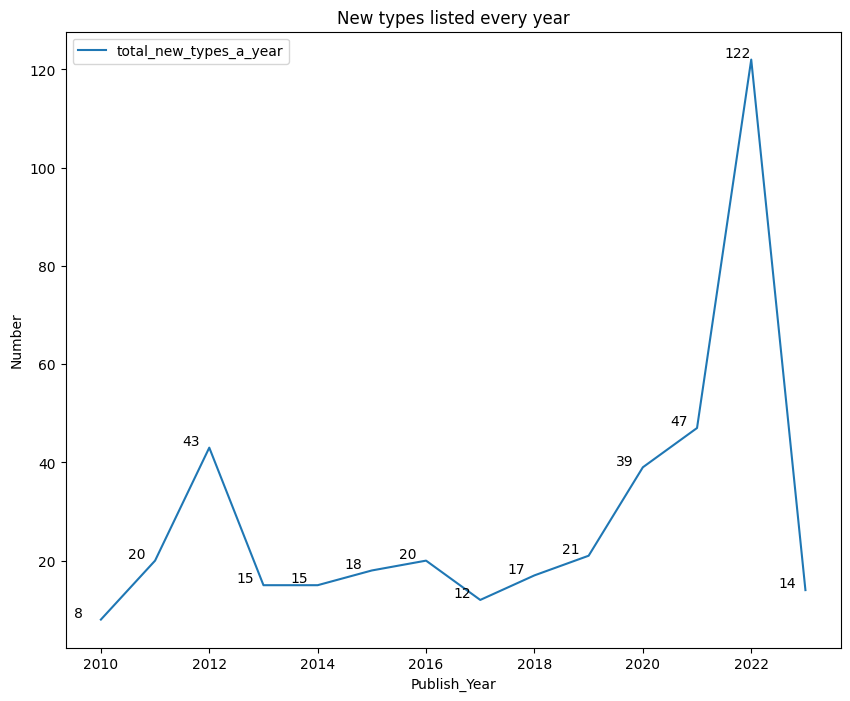

In [ ]:
#dataframe the series ['上市年份'] in the orignal dataframe and count a certain year's show-up times
df_total = pd.DataFrame(Useful_pad_info['上市年份'].value_counts())

#reset the new dataframe's column name
year_count = df_total.reset_index()
year_count.rename(
    columns = {"index" : "year", '上市年份' : 'total_new_types_a_year'}, 
    inplace = True,
    ) 

#Make the elements in the 'year' column be int
year_count['year'] = year_count['year'].astype(int)

#sort the elements in 'year' column based on ascending order
year_count.sort_values(by = 'year', ascending = True, inplace = True)
print(year_count)

#draw a line plot
year_count.plot(kind = 'line', x = 'year', y = 'total_new_types_a_year', figsize = (10, 8))

#add labels to axis x and y 
plt.xlabel('Publish_Year')
plt.ylabel('Number')

#add a title to the plot
plt.title('New types listed every year')

#add the annotation to the spots which make up the line
x = year_count['year'].tolist()#turn the series in pandas to list
y = year_count['total_new_types_a_year'].tolist()
text_0 = []
for i in y:
  text_0.append(str(i))

#Loop for annotation of all points
for i in range(len(x)):
  plt.annotate(text_0[i], (x[i] - 0.5, y[i] + 0.5)) #adjusting the position of the annotation
plt.show()



In [31]:
year_df = pd.DataFrame(Useful_pad_info.loc[Useful_pad_info['上市年份'] == 2010])
print(year_df) 



    公司名称                   产品名称    上市年份  价格(元)  运行内存(GB)  存储容量(GB)  \
101   苹果     苹果iPad（16GB/WiFi版）  2010.0   3200       NaN      16.0   
110   苹果     苹果iPad（32GB/WiFi版）  2010.0   3450       NaN      32.0   
111   苹果     苹果iPad（64GB/WiFi版）  2010.0   3650       NaN      64.0   
161   苹果  苹果iPad（16GB/WiFi+3G版）  2010.0   3400       NaN      16.0   
162   苹果  苹果iPad（32GB/WiFi+3G版）  2010.0   3650       NaN      32.0   
163   苹果  苹果iPad（64GB/WiFi+3G版）  2010.0   3800       NaN      64.0   
391   台电        台电T720-3GE（8GB）  2010.0   1580       NaN       NaN   
406   台电       台电T720-WiFi（8GB）  2010.0    930       NaN       NaN   

           操作系统 处理器型号  屏幕尺寸(英寸)     屏幕分辨率  重量(g)  评论人数   评分 电池类型 电池容量  
101         iOS   NaN       9.7  1024×768  692.0    23  7.4  锂电池  NaN  
110         iOS   NaN       9.7  1024×768  692.0    23  7.4  锂电池  NaN  
111         iOS   NaN       9.7  1024×768  692.0    23  7.4  锂电池  NaN  
161         iOS   NaN       9.7  1024×768  730.0    10  8.0  NaN  NaN  
162      

##5. What is the relationship between the price and pad storage capacity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 94 to 416
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   公司名称      22 non-null     object 
 1   产品名称      22 non-null     object 
 2   上市年份      22 non-null     float64
 3   价格(元)     22 non-null     int64  
 4   运行内存(GB)  17 non-null     float64
 5   存储容量(GB)  22 non-null     float64
 6   操作系统      22 non-null     object 
 7   处理器型号     18 non-null     object 
 8   屏幕尺寸(英寸)  22 non-null     float64
 9   屏幕分辨率     22 non-null     object 
 10  重量(g)     11 non-null     float64
 11  评论人数      22 non-null     int64  
 12  评分        22 non-null     float64
 13  电池类型      22 non-null     object 
 14  电池容量      0 non-null      object 
dtypes: float64(6), int64(2), object(7)
memory usage: 2.8+ KB
     公司名称                    产品名称    上市年份  价格(元)  运行内存(GB)  存储容量(GB)  \
94     苹果     苹果iPod touch 4（8GB）  2012.0   1350       NaN       8.0   
153    苹果  苹果iPod touch 4 

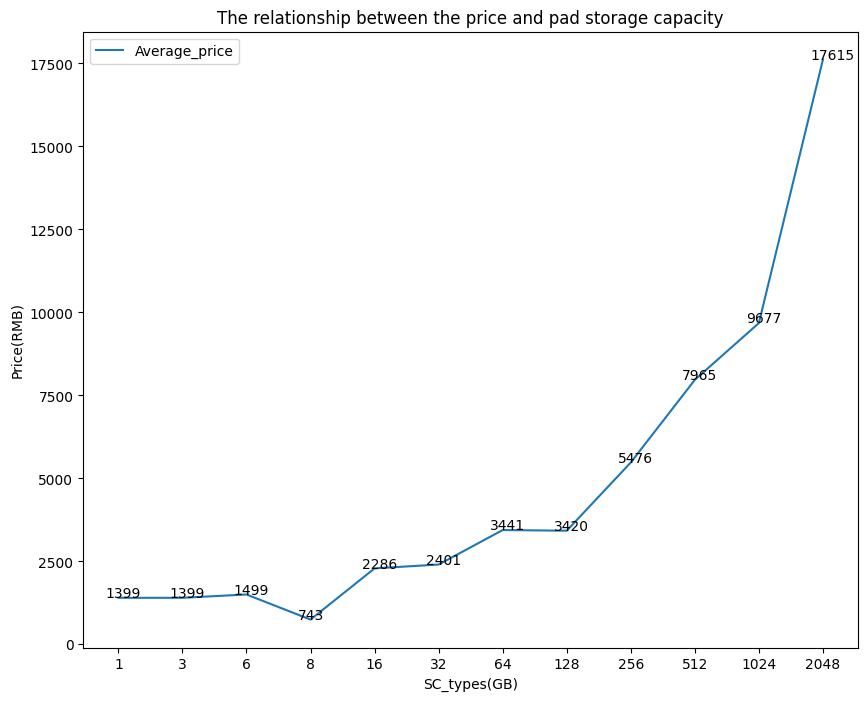

In [32]:
#Find out how many different storage capacities in this dataframe 
SC_count = pd.DataFrame(Useful_pad_info['存储容量(GB)'].value_counts())

#reset the new dataframe's column name
SC_count = SC_count.reset_index()
SC_count.rename(
    columns = {"index" : "Storage_capacity(GB)", '存储容量(GB)' : 'Number_of_types'}, 
    inplace = True,
    ) 

#Make the elements in the 'Storage_capacity(GB)' column be int
SC_count['Storage_capacity(GB)'] = SC_count['Storage_capacity(GB)'].astype(int)

#Sort the elements in 'Storage_capacity(GB)' column based on ascending order
SC_count.sort_values(by = 'Storage_capacity(GB)', ascending = True, inplace = True)
#print(SC_count)

#Get what we want ----- a list contains all of the types of Storage Capacities
SC_types = SC_count['Storage_capacity(GB)'].tolist()
Average_price = []
for i in SC_types:
  # Select Rows where Column is Equal to a single value in this list
  Price_df = pd.DataFrame(Useful_pad_info.loc[Useful_pad_info['存储容量(GB)'] == i]) #set a new dataframe based on the element's value in the column
  Price_df = Price_df.reset_index()#Make it easier to find the column we want  
  Average_price_of_a_type = Price_df['价格(元)'].mean()#calculate the average price of the column
  Average_price.append(int(Average_price_of_a_type))
#print(Average_price)

#Find out the reason why the price of 8GB Storage Capacity is exceptional 
a = pd.DataFrame(Useful_pad_info.loc[Useful_pad_info['存储容量(GB)'] == 8])
a.info() #There is no missing value
print(a) 
# We find out that this exception is due to extremely cheap price of the type"台电"


#set a new dataframe which can show the relationship between the Storage Capacities and price
#specify x-axis locations
x_ticks = []
for i in range(len(SC_types)):
  i = (i+1) * 10
  x_ticks.append(i)# ensure the intervals was created based on the number of points on the line

Rela_SC_P = {'SC_types' : SC_types,
              'Average_price': Average_price,
             'axis_x_intervals': x_ticks #Preparing for set the x_axis
             }
Rela_SC_P = pd.DataFrame(Rela_SC_P)
print(Rela_SC_P)

#draw a line plot
Rela_SC_P.plot(kind = 'line', x = 'axis_x_intervals', y = 'Average_price', figsize = (10, 8))

#specify x-axis labels
x_labels = SC_types

#add x-axis values to plot
plt.xticks(ticks = x_ticks, labels = x_labels)

#add labels to axis x and y 
plt.xlabel('SC_types(GB)')
plt.ylabel('Price(RMB)')

#add a title to the plot
plt.title('The relationship between the price and pad storage capacity')

#add the annotation to the spots which make up the line
x1 = Rela_SC_P['axis_x_intervals'].tolist()# x1 must be consistent with the plot's x-axis.
y1 = Average_price
text_1 = []
for i in y1:
  text_1.append(str(i))

#Loop for annotation of all points
for i in range(len(x1)):
  plt.annotate(text_1[i], (x1[i] - 2, y1[i] + 10)) #adjusting the position of the annotation

plt.show()

In [15]:
#The number of types of every brand
#df.set_index('公司名称', inplace=True)
countofbrand = pd.DataFrame(Useful_pad_info['公司名称'].value_counts())
company_count = countofbrand.reset_index()
company_count.rename(
    columns = {"index" : "company_name", "公司名称" : "total"},
    inplace = True)
print(company_count)

  company_name  total
0           苹果    166
1         酷比魔方     77
2           华为     64
3           台电     35
4           三星     33
5           联想     29
6           荣耀     23
7           小米     13
8           中柏      8
9           微软      5


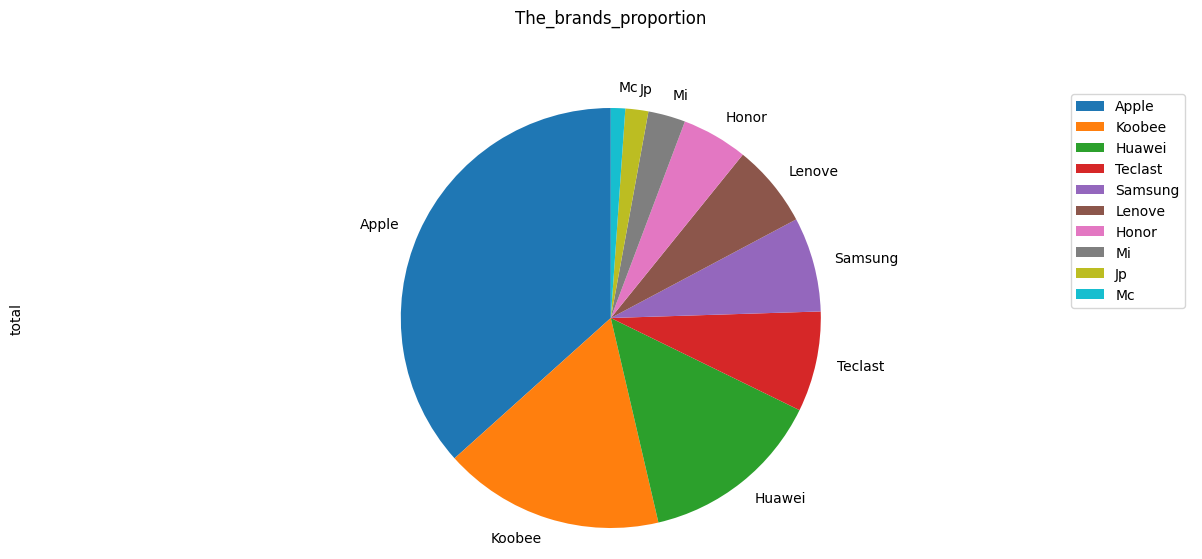

In [19]:
company_count.plot(kind='pie', x = "company_count", y = "total",
                            figsize=(15, 6),
                             
                            startangle=90,    
                            #labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            #colors=colors_list,  # add custom colors
                            #explode=explode_list # 'explode' Africa, Oceania and Northern Americ
                            labels=['Apple', 'Koobee', 'Huawei', 'Teclast', 'Samsung', 'Lenove', 'Honor', 'Mi', 'Jp', 'Mc']
                            )

# scale the title up by 12% to match pctdistance
plt.title('The_brands_proportion', y=1.12) 

plt.axis('equal') # avoid legend overlaps with pie chart

plt.show()

In [26]:
countofyear = pd.DataFrame(Useful_pad_info['上市年份'].value_counts())
year_count = countofyear.reset_index()
year_count.rename(
    columns = {"index" : "year", "上市年份" : "total"},
    inplace = True)
print(year_count)

      year  total
0   2022.0    122
1   2021.0     47
2   2012.0     43
3   2020.0     39
4   2019.0     21
5   2011.0     20
6   2016.0     20
7   2015.0     18
8   2018.0     17
9   2013.0     15
10  2014.0     15
11  2023.0     14
12  2017.0     12
13  2010.0      8


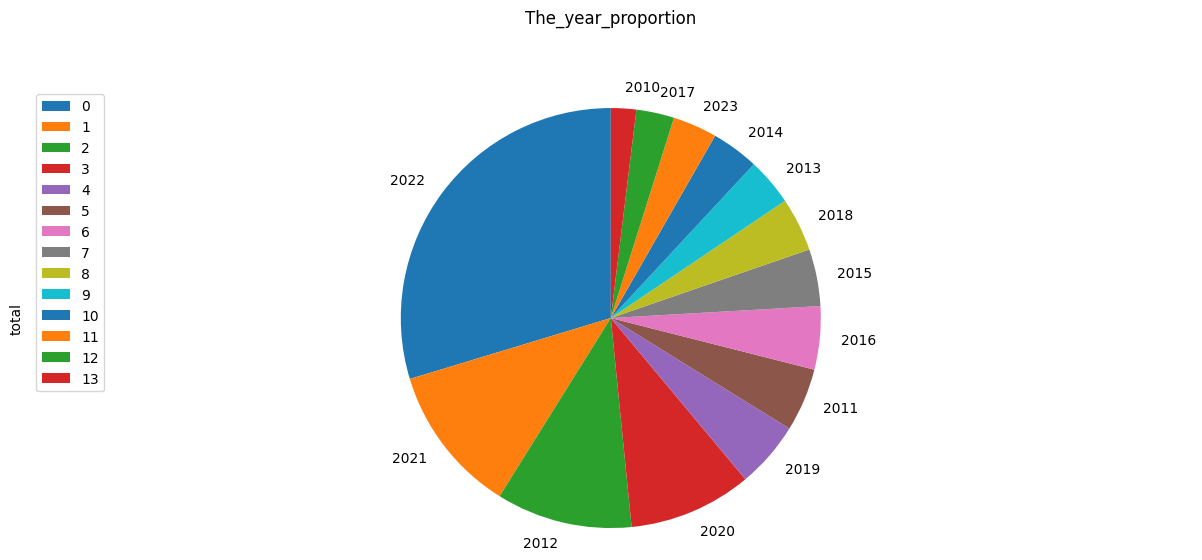

In [21]:
year_count.plot(kind='pie', x = "year_count", y = "total",
                            figsize=(15, 6),
                             
                            startangle=90,    
                            #labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            #colors=colors_list,  # add custom colors
                            #explode=explode_list # 'explode' Africa, Oceania and Northern America
                            labels=['2022', '2021', '2012', '2020', '2019', '2011', '2016', '2015', '2018', '2013', '2014', '2023', '2017', '2010']
                            )

# scale the title up by 12% to match pctdistance
plt.title('The_year_proportion', y=1.12) 

plt.axis('equal') # avoid legend overlaps with pie chart

# add legend
plt.legend(labels=year_count.index, loc='upper left') 

plt.show()

In [27]:
a = pd.DataFrame(pad_info['屏幕尺寸(英寸)'].value_counts())
screensize_count = a.reset_index()
screensize_count.rename(
        columns = {"index" : "screensize_inch", "屏幕尺寸(英寸)" : "Type_number_a_screensize"},
        inplace = True)
#Sort the elements in 'Storage_capacity(GB)' column based on ascending order
screensize_count.sort_values(by = 'screensize_inch', ascending = True, inplace = True)
print(screensize_count)
screensize_inch = screensize_count['screensize_inch'].tolist()
Type_number_a_screensize = screensize_count['Type_number_a_screensize'].tolist()

    screensize_inch  Type_number_a_screensize
7              3.50                        15
19             4.00                         4
25             4.30                         2
24             5.00                         3
3              7.00                        35
8              7.90                        14
6              8.00                        17
20             8.30                         4
17             8.40                         6
21             8.80                         4
31             9.00                         1
33             9.60                         1
1              9.70                        62
30            10.00                         1
5             10.10                        27
16            10.20                         6
35            10.30                         1
4             10.40                        34
13            10.50                         9
15            10.60                         7
10            10.80               

    screensize_inch  Type_number_a_screensize  axis_x_intervals
0              3.50                        15                 2
1              4.00                         4                 4
2              4.30                         2                 6
3              5.00                         3                 8
4              7.00                        35                10
5              7.90                        14                12
6              8.00                        17                14
7              8.30                         4                16
8              8.40                         6                18
9              8.80                         4                20
10             9.00                         1                22
11             9.60                         1                24
12             9.70                        62                26
13            10.00                         1                28
14            10.10                     

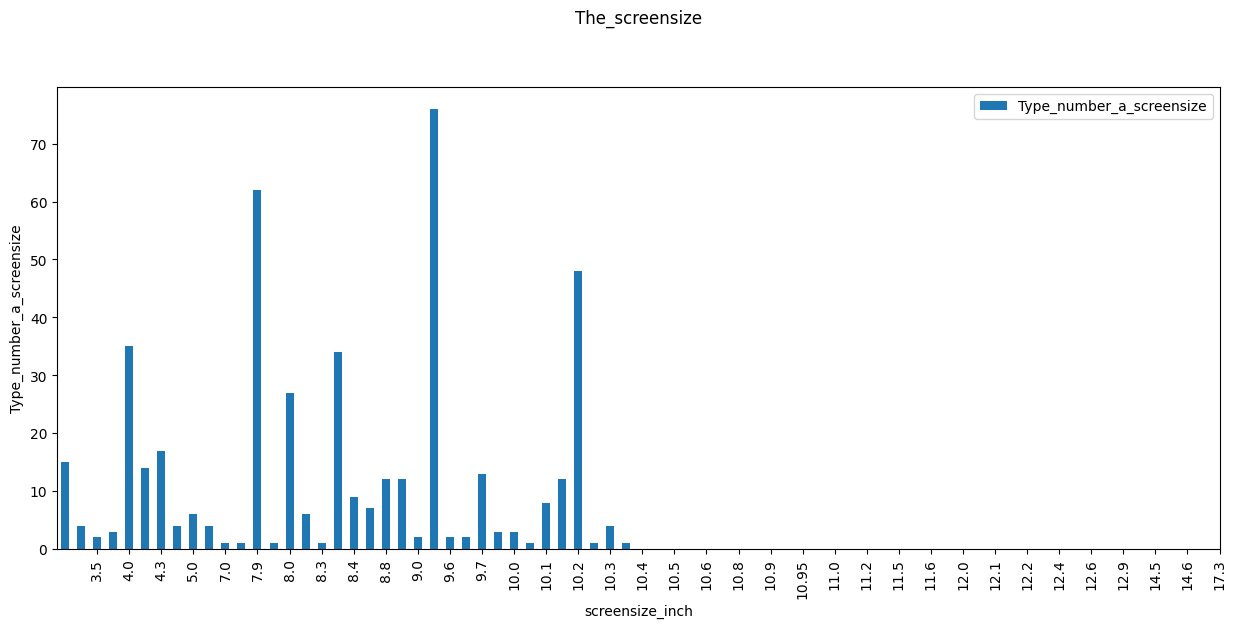

In [25]:
# set a new dataframe which can show the relationship between the Storage Capacities and price
#specify x-axis locations
x_ticks_2 = []

for i in range(len(screensize_inch)):
  i = (i+1)*2 
  x_ticks_2.append(i)

New_screensize_count_df = {'screensize_inch' : screensize_inch,
              'Type_number_a_screensize': Type_number_a_screensize,
             'axis_x_intervals': x_ticks_2 #Preparing for set the x_axis
             }
New_screensize_count_df = pd.DataFrame(New_screensize_count_df)
print(New_screensize_count_df)

#draw a bar plot
New_screensize_count_df.plot(kind='bar', x = "axis_x_intervals", y = "Type_number_a_screensize", figsize=(15, 6))

#add labels to axis x and y 
plt.xlabel('screensize_inch')
plt.ylabel('Type_number_a_screensize')

#specify x-axis labels
x_labels_2 = screensize_inch

#add x-axis values to plot
plt.xticks(ticks = x_ticks_2, labels = x_labels_2)
                                                             
plt.title('The_screensize', y=1.12)

# plt.legend(labels=screensize_count.index, loc='upper left')
plt.show()

In [30]:
# The numbers of types of tablet with different storage capacities
a = pd.DataFrame(pad_info['存储容量(GB)'].value_counts())
GB_count = a.reset_index()
GB_count.rename(
        columns = {"index" : "storageGB", "存储容量(GB)" : "total"},
        inplace = True)
print(GB_count)

    storageGB  total
0       128.0    116
1        64.0     79
2       256.0     66
3        32.0     44
4       512.0     33
5        16.0     32
6         8.0     22
7      1024.0     19
8      2048.0      6
9         1.0      2
10        3.0      1
11        6.0      1


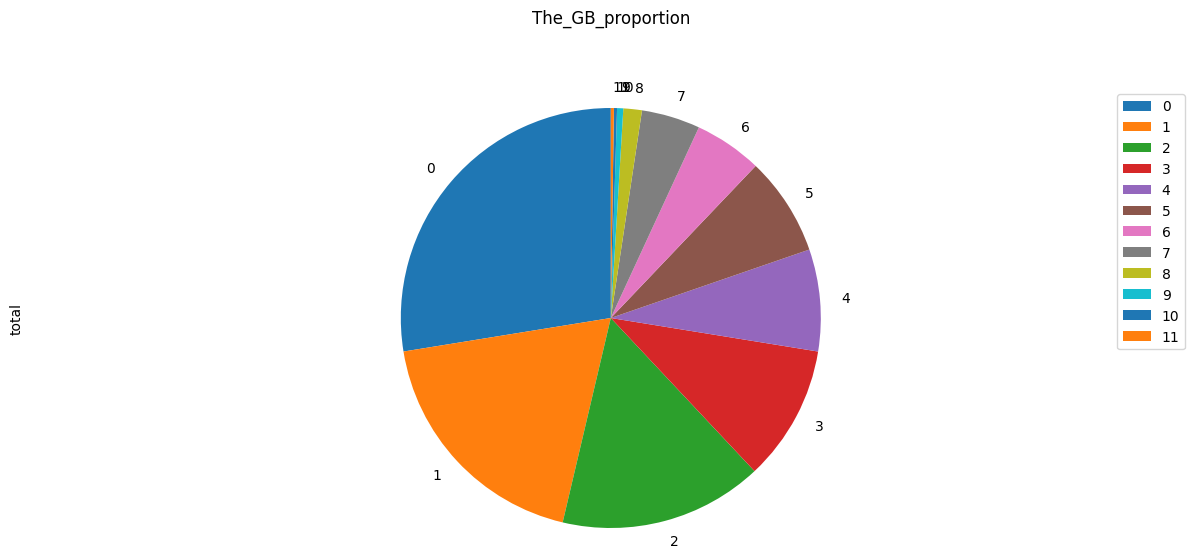

In [29]:
GB_count.plot(kind='pie', x = "GB_count", y = "total",
                                              figsize=(15,6),
                                              
                                              startangle=90,
                                              pctdistance=1.12,
                                              )
plt.title('The_GB_proportion', y=1.12)
plt.axis('equal')
# plt.legend(labels=GB_count.index, loc='upper left')

plt.show()